In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score

import seaborn as sns
import pickle

In [2]:
data_dir = '/Users/pakawanc/OneDrive - Chulalongkorn University/Project/VR/euro-neurips-vrp-2022-quickstart/misc'
model_dir = '/Users/pakawanc/Library/CloudStorage/OneDrive-ChulalongkornUniversity/Project/VR/euro-neurips-vrp-2022-quickstart/baselines/postone/pretrained'
BIGINT = 1e9

In [3]:
# list_path = [file for file in os.listdir(data_dir) if 'data_collectpostone_' in file]
# list_dat = []
# for path in list_path:
#     temp = pd.read_csv(os.path.join(data_dir,path))
#     list_dat.append(temp)
# df_postone = pd.concat(list_dat,axis=0)
# df_postone.to_csv(os.path.join(data_dir,'data_collectpostone.csv'),index=False)

In [4]:
df_greedy = pd.read_csv(os.path.join(data_dir,'data_greedy.csv'))
df_postone = pd.read_csv(os.path.join(data_dir,'data_collectpostone.csv'))

print('len df_greedy : ',len(df_greedy))
print('len df_postone : ',len(df_postone))

len df_greedy :  500
len df_postone :  35000


In [5]:
raw_df = df_postone.merge(df_greedy.rename(columns={'cost':'cost_greedy'}) \
                              .drop(['postpone_epoch','postpone_seed'],axis=1),
                        on=['instance_seed','instance'], how='inner')

# print(raw_df[raw_df.cost_greedy.isna()][['instance','instance_seed']])
print('len df : ',len(raw_df))
assert len(raw_df)==len(df_postone), f'Size of df {len(raw_df)} != df_postone {len(df_postone)}'

len df :  35000


### Feature Engineering

In [6]:
# Filter last epoch data
df = raw_df[raw_df['avg_dur_with_must_dispatch'].notna()].reset_index()

In [7]:
df[['cost','cost_greedy']] = df[['cost','cost_greedy']].astype('int')

df['diff_cost'] = df['cost']-df['cost_greedy']
df['label'] = np.where(df['diff_cost'] < 0, 1, 0)

In [8]:
# col_rank = [col for col in df.columns if 'rank_duration' in col]
# col_is_null = [f'is_rank_null_{i+1}' for i in range(len(col_rank))]

# tmp = df[col_rank].apply(lambda x: (x==1e9).astype('int')).rename(columns={k:v for k,v in zip(col_rank,col_is_null)})
# df = pd.concat([df,tmp],axis=1)
df = df.drop(['index','cost','instance_seed','instance',
               'postpone_epoch','postpone_seed','cost_greedy','diff_cost'],axis=1)

In [9]:
df.shape
# should be (xx, 108) features=107, label=1

(27130, 108)

In [10]:
df.label.value_counts(normalize=True)

1    0.571766
0    0.428234
Name: label, dtype: float64

In [11]:
y = df.label
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

### Preprocess features

In [12]:
nominal_col = [c for c in X.columns if 'is_rank_null' in c]
num_col = list(set(X.columns)-set(nominal_col))

In [13]:
print(nominal_col)
print('all features : ',len(X.columns))
print('nominal features : ',len(nominal_col))
print('num features : ',len(num_col))

[]
all features :  107
nominal features :  0
num features :  107


In [14]:
mapper = DataFrameMapper([([c], StandardScaler()) for c in num_col] +
                         [([c], OneHotEncoder(sparse=False,drop='first')) for c in nominal_col],
                         df_out=False)

### Modeling

In [15]:
models = [
           {'name': 'logisticregression',
           'model': LogisticRegression(),
           'param_grid': {
                    'logisticregression__C': [0.01,0.1,0.5,1,5,10,100],
                    'logisticregression__penalty': ['l1'],
                    'logisticregression__solver': ['saga']
                } 
            },
          ]

In [16]:
def tune_models_hyperparams(X, y, models, **common_grid_kwargs):
    grids = {}
    for model in models:
        print('{:-^70}'.format(' [' + model['name'] + '] '))
        
        pipe = None
        
        # Check whether model is LR
        if model['name'] != 'logisticregression':
            # If not LR -> do feature selection first
            pipe = Pipeline([("mapper", mapper),
                             ('rfe', RFE(estimator=model['model'])),
                             (model['name'], model['model'])])
        else:
            # If LR -> no need (feature selection implemented by regularization)
            pipe = Pipeline([("mapper", mapper),
                             (model['name'], model['model'])])
        
        grids[model['name']] = (GridSearchCV(pipe,
                                             param_grid=model['param_grid'],
                                             **common_grid_kwargs)
                                    .fit(X, y))

    return grids

def print_grid_results(grids):
    for name, model in grids.items():
        print('{:-^70}'.format(' [' + name + '] '))
        print('Score:\t\t{:.2%}'.format(model.best_score_))
        print('Parameters:\t{}'.format(model.best_params_))
        print('*' * 70)

In [17]:
# Training
grid = tune_models_hyperparams(X_train, y_train, models, verbose=1, n_jobs=-1,
                               scoring='roc_auc', cv=5, return_train_score=True)

print_grid_results(grid)

------------------------ [logisticregression] ------------------------
Fitting 5 folds for each of 7 candidates, totalling 35 fits
------------------------ [logisticregression] ------------------------
Score:		69.48%
Parameters:	{'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
**********************************************************************


/Users/pakawanc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Model Evaluation

In [18]:
def test_dataset(grid, X_test, y_test, cutoff=0.5):
    y_pred = {}
    res = {}
    for name, model in grid.items():
        y_pred[name] = (model.predict_proba(X_test)[:,1] >= cutoff).astype(int)
        res[name] = {'AUC' : round(roc_auc_score(y_test, y_pred[name]), 5),
                     'Accuracy' : round(accuracy_score(y_test, y_pred[name]), 5)} 
    
    return res, y_pred

In [19]:
# Predict with train set
result_train,_ = test_dataset(grid, X_train, y_train, cutoff=0.5)
pd.DataFrame(result_train).T

,AUC,Accuracy
logisticregression,0.66183,0.69047


In [20]:
# Predict with test set
result,_ = test_dataset(grid, X_test, y_test, cutoff=0.5)
pd.DataFrame(result).T

,AUC,Accuracy
logisticregression,0.65983,0.68725


In [21]:
mod = grid['logisticregression']

pickle.dump(mod,open(os.path.join(model_dir,'model.pth'),'wb'))

### Interpretation

In [22]:
def print_feature(grid):
    featureslist = None
    selected_features = {}
    for name, model in grid.items():
        if name != 'logisticregression':
            # Select the best pipeline
            mmodel = model.best_estimator_
            featureslist = np.array(mmodel['mapper'].transformed_names_)
            selectedidx = mmodel['rfe'].get_support()
            selected_features[name] = featureslist[selectedidx]
            print('{} features : '.format(name))
            print(selected_features[name])
            print('='*70)
        else:
            # Select the best pipeline
            mmodel = model.best_estimator_
            featureslist = np.array(mmodel['mapper'].transformed_names_)
            # Index of non-zero coefficient features
            selectedidx = (mmodel['logisticregression'].coef_ != 0).flatten()
            selected_features[name] = featureslist[selectedidx]
            print('{} features : '.format(name))
            print(selected_features[name])
            print('='*70)
    return featureslist, selected_features

featureslist, selected_features = print_feature(grid)

logisticregression features : 
['rank_duration_49' 'rank_duration_48' 'rank_duration_78'
 'rank_duration_45' 'rank_duration_17' 'rank_duration_1'
 'rank_duration_84' 'rank_duration_2' 'rank_duration_22'
 'rank_duration_53' 'rank_duration_54' 'rank_duration_91'
 'rank_duration_63' 'rank_duration_15' 'rank_duration_82'
 'rank_duration_75' 'rank_duration_73' 'rank_duration_60'
 'rank_duration_16' 'rank_duration_42' 'rank_duration_59'
 'rank_duration_8' 'rank_duration_3' 'rank_duration_88'
 'min_dur_with_must_dispatch' 'rank_duration_74' 'rank_duration_80'
 'rank_duration_10' 'rank_duration_56' 'rank_duration_90' 'capacity'
 'rem_epoch' 'rank_duration_50' 'rank_duration_99' 'rank_duration_37'
 'rank_duration_35' 'avg_demand' 'rank_duration_69' 'rank_duration_43'
 'rank_duration_62' 'rank_duration_92' 'rank_duration_18'
 'rank_duration_70' 'demand_left' 'rank_duration_67' 'rank_duration_89'
 'rank_duration_7' 'rank_duration_32' 'rank_duration_30'
 'rank_duration_29' 'rank_duration_79' 'rank

<AxesSubplot:xlabel='coeff', ylabel='features'>

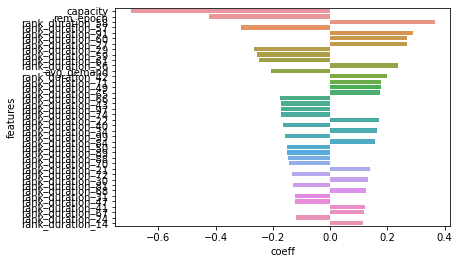

In [23]:
best_estimator = mod.best_estimator_['logisticregression']
coeff_list = best_estimator.coef_.flatten()

dfCoeff = pd.DataFrame({'features':featureslist,
                        'coeff':coeff_list,
                        'impact':abs(coeff_list)}).sort_values('impact',ascending=False).head(40)

sns.barplot(x='coeff',y='features',data=dfCoeff)